In [1]:
#################################
#Run this cell if using Google COLAB
#################################

#clone the repository and the data to run the notebook on Google Colab
!git clone https://github.com/GiancarloCroce/DCA_SARS-CoV-2
%cd ./DCA_SARS-CoV-2
#for plotly on google colab
import plotly.io as pio
pio.renderers.default = 'colab'

Cloning into 'DCA_SARS-CoV-2'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 115 (delta 37), reused 106 (delta 28), pack-reused 0
Receiving objects: 100% (115/115), 6.27 MiB | 3.17 MiB/s, done.
Resolving deltas: 100% (37/37), done.
/home/giancarlo/Documents/lab_work/martin_project_CoVid-19/DCA_SARS-CoV-2/DCA_SARS-CoV-2


In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import pandas as pd
import datetime
from sklearn import preprocessing
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
import plotly.graph_objects as go  
from sklearn import metrics
from utils import load_data_dca, plot_roc, plot_dca_IEDB, plot_dca_IEDB_BTcell
from utils import get_IEDB_versions, compute_RF, get_updated_IEDB,load_VOC

# DCA for SARS-CoV-2


For each site of the SARS-CoV-2 Wuhan-Hu-1 proteome (Accession [NC045512](https://www.genome.jp/dbget-bin/www_bget?refseq:NC_045512)) included in a PFAM domain, we introduce a [Direct Coupling Analysis](https://en.wikipedia.org/wiki/Direct_coupling_analysis) mutability score to predict mutable and constrained sites. Column in the dataframe: **mutability_score(DCA)**.

We validate our mutability predictions with the mutations observed in SARS-CoV-2 strains proteomes deposited in the [GISAID database](https://www.gisaid.org/). We consider 3 different time periods:
1.  Mutation observed from January 2020 to July 2020 (Column: **observed_mut_Jul2020**)
2.  Mutation observed from January 2020 to December 2020 (Column: **observed_mut_Dec2020**)
3.  Mutation observed from January 2020 to May 2021 (Column: **observed_mut_May2021**)

Similarly, we compute the mutability scores using no-epistatic conservation profiles (hereinafter independent models - IND) and compare the performaces with epistatic DCA models. Column in the dataframe: **mutability_score(IND)**.


## Receptor Binding Domain

Here we restrict our analysis to the Receptor Binding Domain (```dom = "bCoV_S1_RBD"```) of the SARS-CoV-2 Spike protein (```prot = "Spike" ```).

In [2]:
# Load data (for a specific protein and domain)
prot = "Spike"
dom = "bCoV_S1_RBD"

df = load_data_dca(path_data = "./data/data_dca_proteome.csv", protein = prot, domain = dom)
print(df)

     protein       domain  position_protein  position_domain aa_Wuhan-Hu-1  \
7448   Spike  bCoV_S1_RBD               349              1.0             S   
7449   Spike  bCoV_S1_RBD               350              2.0             V   
7450   Spike  bCoV_S1_RBD               351              3.0             Y   
7451   Spike  bCoV_S1_RBD               352              4.0             A   
7452   Spike  bCoV_S1_RBD               353              5.0             W   
...      ...          ...               ...              ...           ...   
7621   Spike  bCoV_S1_RBD               522            174.0             A   
7622   Spike  bCoV_S1_RBD               523            175.0             T   
7623   Spike  bCoV_S1_RBD               524            176.0             V   
7624   Spike  bCoV_S1_RBD               525            177.0             C   
7625   Spike  bCoV_S1_RBD               526            178.0             G   

      mutability_score(IND)  mutability_score(DCA)  observed_mu

## 1. Predicting mutable sites

In Fig.2 we use the DCA and IND model to predict mutable and constrained sites.

We validate our mutability predictions with the mutations observed in circulating GISAID strains, defining as:
- **mutable** :  a site with **N_mut or more** observed mutations in GISAID strains
- **constrained** : a site with **less than N_mut**  observed mutations in GISAID strains

Here we fix **N_mut=16** and include GIDAS data from January 2020 to May 2021. 

Try to change **N_mut** to investigate how the predictive performaces are affected by the defition of **mutable** and **constrained** site. 

GISAID data from Jan 2020 to observed_mut_May2021, protein=Spike, domain=bCoV_S1_RBD
- 65 sites are mutable (1)
     a site if considered *mutable* if >= 16 mutations are observed in GISAID
- 113 sites are constrained  0)
     a site if considered *constrained* if < 16 mutations are observed in GISAID


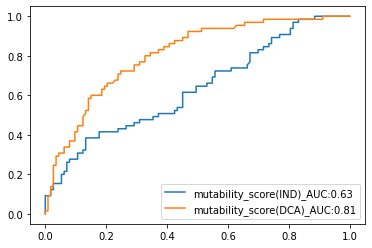

In [3]:
## ROC DCA vs. IND model, FIG.2

# define constrained and mutable sites
N_mut = 16
constrained = range(0,N_mut)
mutable = range(N_mut,1000000) #1000000 a random big number 

# GISAID data 
GISAID = 'observed_mut_May2021'

list_score = ['mutability_score(IND)', 'mutability_score(DCA)']
plot_roc(constrained, mutable, GISAID, list_score, df)


### print some info
num_contrained = np.sum(df[GISAID].isin(constrained))
num_mutable = np.sum(df[GISAID].isin(mutable))


print("GISAID data from Jan 2020 to {0}, protein={1}, domain={2}".format(GISAID,prot, dom))
print("- {0} sites are mutable (1)".format(num_mutable))
print('     a site if considered *mutable* if >= '+str(N_mut) + ' mutations are observed in GISAID')
print("- {0} sites are constrained  0)".format(num_contrained))
print('     a site if considered *constrained* if < '+str(N_mut) + ' mutations are observed in GISAID')

### Mutations are accumulating

Here we access the predictive power of the DCA mutability scores considering 3 different timepoints (July 2020, December 2020, May 2020) for the GISAID data.
We observe an increasing agreement between our model and the observed variability as more data become available over time.

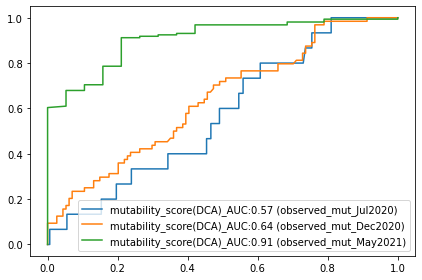

In [4]:
## ROC DCA, GISAID at different time,  FIG.2

# define constrained and mutable sites
N_mut = 4
constrained = range(0,N_mut)
mutable = range(N_mut,1000000) #1000000: a random big number
list_score = ['mutability_score(DCA)']
              
observed_mutability = 'observed_mut_Jul2020'
plot_roc(constrained, mutable, observed_mutability, list_score, df, add_obs_mut = True)
observed_mutability = 'observed_mut_Dec2020'
plot_roc(constrained, mutable, observed_mutability, list_score, df, add_obs_mut = True)
observed_mutability = 'observed_mut_May2021'
plot_roc(constrained, mutable, observed_mutability, list_score, df, add_obs_mut = True)
plt.tight_layout()

## 2. Predicting immunologically relevant mutable sites

Nonsynonymous mutations may modify regions of the SARS-CoV-2 genome targeted by B or T cells (known as B/T cell epitopes). 

The [IEDB](https://www.iedb.org/) website collects experimentally validated B and T cell epitopes.
Each SARS-CoV-2 sites is associated with the corresponding epitope response frequency (RF), defined as the number of positively responded subjects, averaged over all epitopes mapped to that position. See  https://help.iedb.org/hc/en-us/articles/114094147751 for more details.

Amino acid substitution at high-RF sites have a higher risk of inducing immune escape as many positively responding epitopes are modified. 

### DCA and IEDB - paper results
Here we plot the DCA mutability score vs. the IEDB response frequency for each site of the RDB domain (Fig 3B of the paper).

The interesting region is the **upper right corner** containing sites which are expected to be mutable (high DCA score) and that can induce immune escape (high RF).

As in the paper, here we use:
- IDEB epitope data updated on 16 May 2021. 
- WHO weekly epidemiological report on Covid-19 (https://www.who.int/publications/m/item/weekly-epidemiological-update-on-covid-19---18-may-2021) published on 18 May 2021. It classifies 6 SARS-CoV-2 variants as variants of interest (VOI) and 4 as variants of concern (VOC). Within the RBD domain, they have mutations in the 417, 452, 477, 478, 483, 484 and 501 positions (red points in the plot).

In the next cells we repeat the analysis using more recent versions of IEDB data and extending the predictions to other protein domains.

In [16]:
# DCA vs. IEDB response frequency
prot = "Spike"
dom = "bCoV_S1_RBD"
score = 'mutability_score(DCA)'

#positions mutated in VOI/VOC (as of May 2021)
list_pos_mutated_VOI_VOC = [417, 452, 477, 478, 483, 484,  501] #red points

df = load_data_dca(path_data = "./data/data_dca_iedb_RDB_domain.csv", protein = prot, domain = dom)
#print(df)
plot_dca_IEDB(df, score, list_pos = list_pos_mutated_VOI_VOC)

### To plot only B(T) cell epitopes (Fig S6)
#df = load_data_dca(path_data = "./data/data_dca_iedb_RDB_domain_BTcell.csv", protein = prot, domain = dom)
#BT_cell = "B_cell" #"T_cell"
#print('***** {0} epitopes *****'.format(BT_cell))
#plot_dca_IEDB_BTcell(df, score, list_pos = list_pos_mutated_VOI_VOC, cell_type = BT_cell)

    protein       domain  position_protein  position_domain aa_Wuhan-Hu-1  \
68    Spike  bCoV_S1_RBD               417             69.0             K   
103   Spike  bCoV_S1_RBD               452            104.0             L   
128   Spike  bCoV_S1_RBD               477            129.0             S   
129   Spike  bCoV_S1_RBD               478            130.0             T   
134   Spike  bCoV_S1_RBD               483            135.0             V   
135   Spike  bCoV_S1_RBD               484            136.0             E   
152   Spike  bCoV_S1_RBD               501            153.0             N   

     mutability_score(IND)  mutability_score(DCA)  observed_mut_May2021  \
68                  0.0836                -0.4315                 163.0   
103                -1.7534                -0.9576                 289.0   
128                -1.0210                -0.6329                 194.0   
129                -1.5438                -0.6578                 137.0   
134     

0

### DCA and IEDB - UPDATED results

SARS-CoV-2 epitope data are quickly accumulating, and new VOCs/VOIs are emerging.
The https://cov-lineages.org/ websites report observed in VOIs or VOCs.
Here we repeat the same analysis with updated IEDB epitope data and consider the following VOCs:


In [24]:
#list VOC (Dec2021)
df_VOC = load_VOC(path_dir_VOC = "./data/VOC", rm_deletion = True, verbose = False)
#print(df_VOC)

Error with BA.1, pos=['del', '6513', '3']
Error with BA.1, pos=['del', '11283', '9']
Error with BA.1, pos=['N', 'RG203KR']
Error with P.1, pos=['del', '11288', '9']
Error with B.1.1.7, pos=['del', '11288', '9']
Error with B.1.1.7, pos=['del', '21765', '6']
Error with B.1.1.7, pos=['del', '21991', '3']


In [25]:
#Let's restrict the analysis to mutations occurred on the Spike protein
prot = "Spike"
df_VOC_prot = df_VOC.loc[df_VOC['protein'] ==prot] 
print(df_VOC_prot)
list_pos_mutated = df_VOC_prot['position'].astype(int).values
print("mutated sites:", list_pos_mutated)

        pango      who mutation_type protein mutation  position
3     B.1.351     Beta            aa   Spike     D80A        80
4     B.1.351     Beta            aa   Spike    D215G       215
5     B.1.351     Beta            aa   Spike    K417N       417
6     B.1.351     Beta            aa   Spike    A701V       701
7     B.1.351     Beta            aa   Spike    N501Y       501
8     B.1.351     Beta            aa   Spike    E484K       484
16       BA.1  Omicron            aa   Spike     A67V        67
17       BA.1  Omicron            aa   Spike     T95I        95
18       BA.1  Omicron            aa   Spike    G339D       339
19       BA.1  Omicron            aa   Spike    S371L       371
20       BA.1  Omicron            aa   Spike    S373P       373
21       BA.1  Omicron            aa   Spike    K417N       417
22       BA.1  Omicron            aa   Spike    N440K       440
23       BA.1  Omicron            aa   Spike    G446S       446
24       BA.1  Omicron            aa   S

In [70]:
'''
DCA mutability score vs. the IEDB response frequency 
highlighting position mutated in Variants of Concerns (list_pos_mutated)
'''

score = 'mutability_score(DCA)'
#for DCA predictions, we need to specify a PFAM domain. 
#Here we consider the Receptor Binding Domain of the Spike Protein
dom = "bCoV_S1_RBD"

print("DCA mutability predictions vs. IEDB response frequency data \n for the *** {0} domain of the {1} protein ***".format(dom,prot))  

df = load_data_dca(path_data = "./data/data_dca_proteome.csv", protein = prot, domain = dom)

#get IEDB available versions:
path_IEDB_updated_data = "./data/IEDB_updated_data/{0}".format(prot)
list_IEDB_versions =  get_IEDB_versions(path_IEDB_epitope_data = path_IEDB_updated_data )

IEDB_ver = '05Dec2021'
df = get_updated_IEDB(df, IEDB_ver, path_IEDB_updated_data)


plot_dca_IEDB(df, score, list_pos = list_pos_mutated)

DCA mutability predictions vs. IEDB response frequency data 
 for the *** bCoV_S1_RBD domain of the Spike protein ***
IEDB available versions: ['05Dec2021']
Selecting *** IEDB 05Dec2021 version ***
    protein       domain  position_protein  position_domain aa_Wuhan-Hu-1  \
22    Spike  bCoV_S1_RBD               371             23.0             S   
24    Spike  bCoV_S1_RBD               373             25.0             S   
67    Spike  bCoV_S1_RBD               417             69.0             K   
89    Spike  bCoV_S1_RBD               440             92.0             N   
95    Spike  bCoV_S1_RBD               446             98.0             G   
101   Spike  bCoV_S1_RBD               452            104.0             L   
126   Spike  bCoV_S1_RBD               477            129.0             S   
127   Spike  bCoV_S1_RBD               478            130.0             T   
133   Spike  bCoV_S1_RBD               484            136.0             E   
142   Spike  bCoV_S1_RBD        

0

In [72]:
# The same scatterplot, but considering each VOC separately:

prot = 'Spike'
dom = "CoV_S1_C"
score = 'mutability_score(DCA)'
df = load_data_dca(path_data = "./data/data_dca_proteome.csv", protein = prot, domain = dom)

#get IEDB available versions:
path_IEDB_updated_data = "./data/IEDB_updated_data/{0}".format(prot)
list_IEDB_versions =  get_IEDB_versions(path_IEDB_epitope_data = path_IEDB_updated_data )

IEDB_ver = '05Dec2021'
df = get_updated_IEDB(df, IEDB_ver, path_IEDB_updated_data)

#add VOC red dot
df_VOC_prot = df_VOC.loc[df_VOC['protein'] ==prot] 

for name_VOC, df_one_VOC in df_VOC_prot.groupby(by = ['pango', 'who']):
    print(name_VOC)
    list_pos_mutated_VOC = df_one_VOC['position'].astype(int).values
    plot_dca_IEDB(df, score, list_pos = list_pos_mutated_VOC)

IEDB available versions: ['05Dec2021']
Selecting *** IEDB 05Dec2021 version ***
('B.1.1.7', 'Alpha')
   protein    domain  position_protein  position_domain aa_Wuhan-Hu-1  \
34   Spike  CoV_S1_C               570             35.0             A   

    mutability_score(IND)  mutability_score(DCA)  observed_mut_May2021  \
34                 0.3024                 0.6038                 165.0   

    observed_mut_Dec2020  observed_mut_Jul2020  IEDB_lowerbound  \
34                   4.0                   1.0             0.44   

    IEDB_upperbound  subj_tested  subj_responded  IEDB_response_frequency  \
34             0.49         1606             750                 0.466999   

    size_scatter  
34          20.0  


('B.1.351', 'Beta')
Empty DataFrame
Columns: [protein, domain, position_protein, position_domain, aa_Wuhan-Hu-1, mutability_score(IND), mutability_score(DCA), observed_mut_May2021, observed_mut_Dec2020, observed_mut_Jul2020, IEDB_lowerbound, IEDB_upperbound, subj_tested, subj_responded, IEDB_response_frequency, size_scatter]
Index: []


('B.1.617.2', 'Delta')
Empty DataFrame
Columns: [protein, domain, position_protein, position_domain, aa_Wuhan-Hu-1, mutability_score(IND), mutability_score(DCA), observed_mut_May2021, observed_mut_Dec2020, observed_mut_Jul2020, IEDB_lowerbound, IEDB_upperbound, subj_tested, subj_responded, IEDB_response_frequency, size_scatter]
Index: []


('BA.1', 'Omicron')
   protein    domain  position_protein  position_domain aa_Wuhan-Hu-1  \
11   Spike  CoV_S1_C               547             12.0             T   

    mutability_score(IND)  mutability_score(DCA)  observed_mut_May2021  \
11                -1.4125                -0.9133                  17.0   

    observed_mut_Dec2020  observed_mut_Jul2020  IEDB_lowerbound  \
11                   1.0                   0.0             0.19   

    IEDB_upperbound  subj_tested  subj_responded  IEDB_response_frequency  \
11             0.24          977             213                 0.218014   

    size_scatter  
11          20.0  


('P.1', 'Gamma')
Empty DataFrame
Columns: [protein, domain, position_protein, position_domain, aa_Wuhan-Hu-1, mutability_score(IND), mutability_score(DCA), observed_mut_May2021, observed_mut_Dec2020, observed_mut_Jul2020, IEDB_lowerbound, IEDB_upperbound, subj_tested, subj_responded, IEDB_response_frequency, size_scatter]
Index: []


## 3. DCA vs. IEDB predictions for other protein domains
DCA predictions are available for the following proteins and protein domains, with

 - **M_eff** = the effective number of sequences used for training the DCA model
 - **L** = the length of the protein domain
 
As discussed in the paper, the more sequence data is available to train the DCA (Meff) model, the better the variable site predictions are.

In [44]:
data_prot_domain = pd.read_csv("./data/data_meff.csv")
print(data_prot_domain)

         protein           domain Pfam_accession  M_eff    L
0       Envelope            CoV_E     PF02723.15     53   66
1       Membrane            CoV_M     PF01635.19     38  201
2   Nucleocapsid    CoV_nucleocap     PF00937.19     48  341
3          ORF1a         bCoV_NAR      PF16251.6     19   98
4          ORF1a        bCoV_NSP1      PF11501.9     12  135
5          ORF1a      bCoV_NSP3_N      PF12379.9      9  171
6          ORF1a       bCoV_SUD_C      PF12124.9      2   64
7          ORF1a       bCoV_SUD_M      PF11633.9     10  143
8          ORF1a        CoV_NSP10     PF09401.11     25  123
9          ORF1a       CoV_NSP2_C      PF19212.1     22  167
10         ORF1a       CoV_NSP2_N      PF19211.1     25  241
11         ORF1a       CoV_NSP3_C      PF19218.1     58  488
12         ORF1a       CoV_NSP4_C      PF16348.6     33   96
13         ORF1a       CoV_NSP4_N      PF19217.1     58  354
14         ORF1a         CoV_NSP6      PF19213.1     71  262
15         ORF1a        

In [66]:
'''
Let's repeat the analysis DCA mutability score vs. the IEDB response frequency 
for the CoV_S2_C domain of the Spike protein
highlighting position mutated in Variants of Concerns (list_pos_mutated)
'''
prot = 'Spike'
dom = "CoV_S1_C"
score = 'mutability_score(DCA)'
df = load_data_dca(path_data = "./data/data_dca_proteome.csv", protein = prot, domain = dom)

#get IEDB available versions:
path_IEDB_updated_data = "./data/IEDB_updated_data/{0}".format(prot)
list_IEDB_versions =  get_IEDB_versions(path_IEDB_epitope_data = path_IEDB_updated_data )

IEDB_ver = '05Dec2021'
df = get_updated_IEDB(df, IEDB_ver, path_IEDB_updated_data)

#add VOC red dot
df_VOC_prot = df_VOC.loc[df_VOC['protein'] ==prot] 
list_pos_mutated = df_VOC_prot['position'].astype(int).values

plot_dca_IEDB(df, score, list_pos = list_pos_mutated)

IEDB available versions: ['05Dec2021']
Selecting *** IEDB 05Dec2021 version ***
   protein    domain  position_protein  position_domain aa_Wuhan-Hu-1  \
11   Spike  CoV_S1_C               547             12.0             T   
34   Spike  CoV_S1_C               570             35.0             A   

    mutability_score(IND)  mutability_score(DCA)  observed_mut_May2021  \
11                -1.4125                -0.9133                  17.0   
34                 0.3024                 0.6038                 165.0   

    observed_mut_Dec2020  observed_mut_Jul2020  IEDB_lowerbound  \
11                   1.0                   0.0             0.19   
34                   4.0                   1.0             0.44   

    IEDB_upperbound  subj_tested  subj_responded  IEDB_response_frequency  \
11             0.24          977             213                 0.218014   
34             0.49         1606             750                 0.466999   

    size_scatter  
11          20.0  
34   

0